In [1]:
import sys
import math
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
from models.radar import radar_factory
import math
from models.sc_net import SCnet
import pickle
from dataset.tmQM_data import tmQM_dataset,tmQM_wrapper
import yaml
from dataset.prepocess import draw_entirety
from dataset.prepocess import draw_ligands
from tqdm import tqdm
import sklearn.metrics as sm

In [5]:
LABEL_NAME = ['EE','DE','\u03BC','MC','H/L Gap','HOMO-E','LUMO-E','\u03B1']

# 标签顺序
rank = [0,5,3,1,2,6,7,4]
label = [LABEL_NAME[i] for i in rank]

def read_data(experiments):
    root_dir = './experiment/'
    means = []
    stds = []
    for exper in experiments:
        path = root_dir + exper + '/result.csv'
        data = pd.read_csv(path).to_numpy()
        means.append(np.mean(data,axis=0))
        stds.append(np.std(data,axis=0))
    means = np.array(means)
    stds = np.array(stds)
    return means,stds

In [6]:
def radar(data,label,index,title):
    N = 8
    data.append([0 for i in range(8)])
    theta = radar_factory(N, frame='polygon')
    spoke_labels = label
    
    fig, axs = plt.subplots(figsize=(9,8), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['blue','blueviolet','green', 'orange','gold','slategray','lightseagreen','chocolate',]
    
    ax = axs
    d = data
    ax.set_rgrids([1,2,3,4,5])
    for d, color in zip(data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = index
    legend = ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='medium')

    fig.text(0.5, 0.965, title,
                horizontalalignment='center', color='black', weight='bold',
                size='large')

    plt.savefig('./results/'+title+'.tif',dpi=600)
    plt.show()

In [7]:
def cal_area(data,plot=False,lable=None,title=None):
    areas = [0 for i in range(len(data))]
    for ind,poly in enumerate(data[:-1]):
        for i,r in enumerate(poly):
            if i == 7:
                areas[ind] += 0.5*r*poly[0]*math.sin(math.pi/4)
            else:
                areas[ind] += 0.5*r*poly[i+1]*math.sin(math.pi/4)
    diff = [np.round(areas[i]/areas[0],2) for i in range(0,len(areas)-1)]
    if plot:
        plt.figure(figsize=(6,3))
        plt.plot(lable,diff[:-1],'-',color='dodgerblue')
        plt.plot(lable,diff[:-1],'*',color='dodgerblue')
        plt.savefig('./results/'+title+'.tif',dpi=600)
        plt.show()
    return diff

In [8]:
def table(experiments,title,index,mode='a'):
    times = np.array([0.01,1000,1,100,100,1000,1000,1])
    means,std = read_data(experiments)
    means = np.round(means*times,decimals=2)
    std = np.round(std*times,decimals=2)
    res = []
    for i in range(means.shape[0]):
        res.append([])
        for j in range(means.shape[1]):
            res[-1].append(str(means[i][j])+'\u00B1'+str(std[i][j]))
    df = pd.DataFrame(res,index,LABEL_NAME)
    with pd.ExcelWriter('./results/result.xlsx',mode=mode) as writer:
        df.to_excel(writer,sheet_name=title)

* #### 无金属、简单分离式、分离配位式、完全式对比雷达图

In [12]:
areas = []

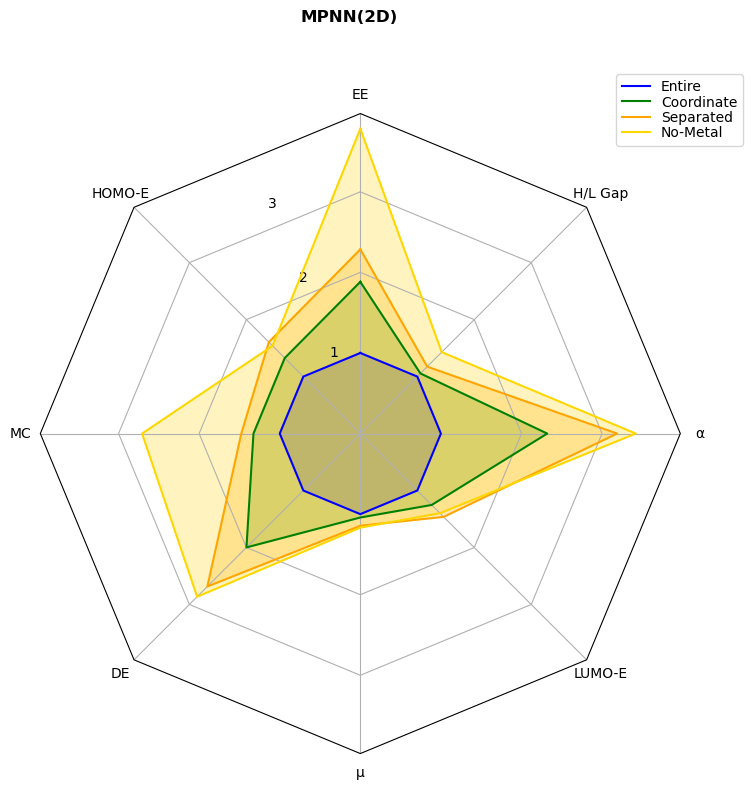

In [13]:
title = 'MPNN(2D)'
experiments = ['SCnet-GCN_en_no_laplace_2d_2d_1','SCnet-GCN_se_att_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','No-Metal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index,title))

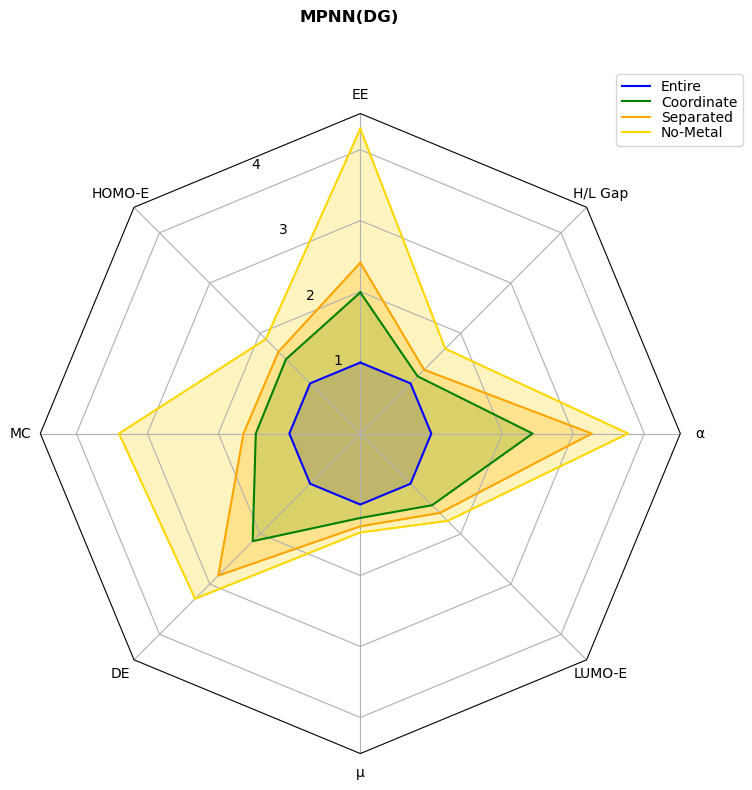

[1.0, 2.63, 3.67, 6.61]

In [41]:
title = 'MPNN(DG)'
experiments = ['MPNN_en_no_DG_2d_3d_1','MPNN_se_att16_DG_2d_3d_1','MPNN_se_no_DG_2d_3d_1','MPNN_se_no_DG_2d_3d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
cal_area(data)

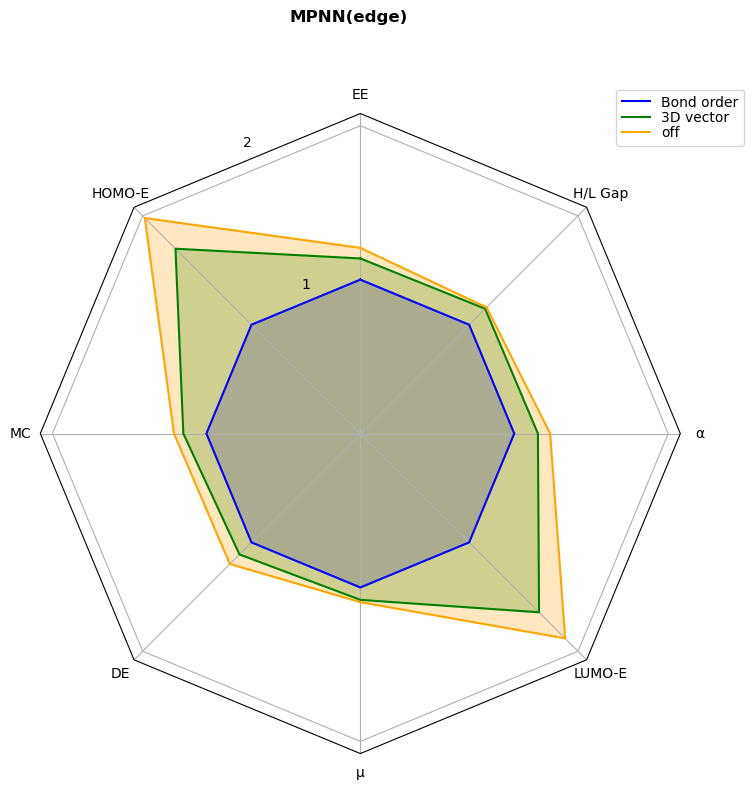

In [38]:
title = 'MPNN(edge)'
experiments = ['MPNN_se_att16_laplace_2d_2d_1','MPNN_se_att16_DG_2d_3d_1','MPNN_se_att16_xyz_2d_off_1']
index = ['Bond order','3D vector','off']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)

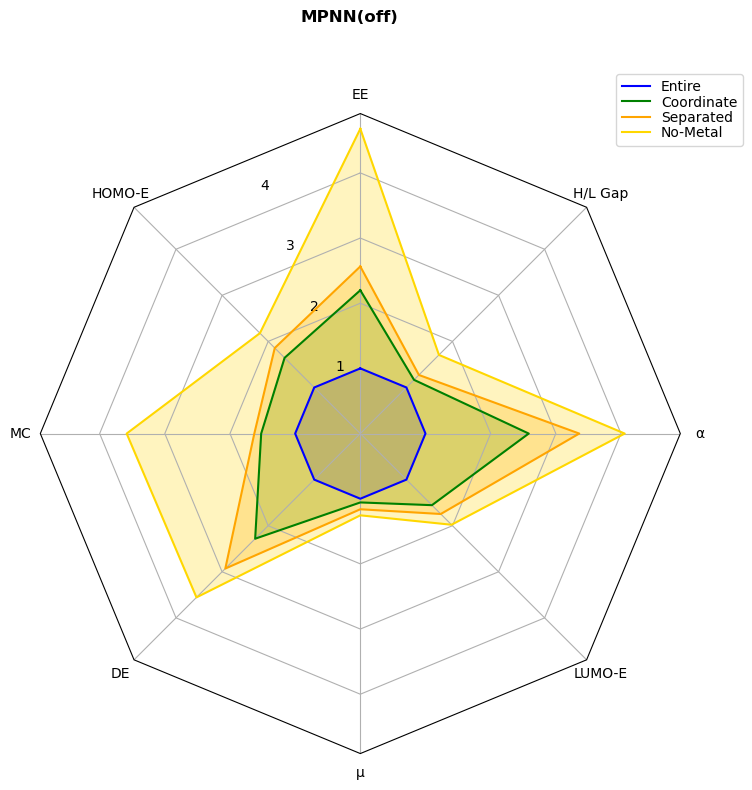

[1.0, 2.9, 3.92, 7.58]

In [42]:
title = 'MPNN(off)'
experiments = ['MPNN_en_no_xyz_2d_off_1','MPNN_se_att16_xyz_2d_off_1','MPNN_se_no_xyz_2d_off_1','MPNN_se_no_xyz_2d_off_0']
index = ['Entire','Coordinate','Separated','No-Metal']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
cal_area(data)

In [15]:
title = 'MPNN(PE)'
experiments = ['MPNN_se_att16_xyz_3d_off_1','MPNN_se_att16_DG_3d_off_1']
index = ['xyz','DG']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)

FileNotFoundError: [Errno 2] No such file or directory: './experiment/MPNN_se_att16_xyz_3d_off_1/result.csv'

In [167]:
title = 'GCN(DG)'
experiments = ['MPNN_en_no_DG_2d_3d_1','MPNN_se_att16_DG_2d_3d_1','MPNN_se_no_DG_2d_3d_1','MPNN_se_no_DG_2d_3d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
areas(cal_area(data))

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.9881, 1.4815, 1.4727, 2.1446, 1.1892, 1.4286, 2.4273, 1.141],
 [2.4061, 1.6303, 1.6457, 2.8308, 1.3069, 1.5831, 3.2604, 1.2711],
 [4.2935, 1.8826, 3.3991, 3.2917, 1.3933, 1.7406, 3.773, 1.6914],
 [0, 0, 0, 0, 0, 0, 0, 0]]

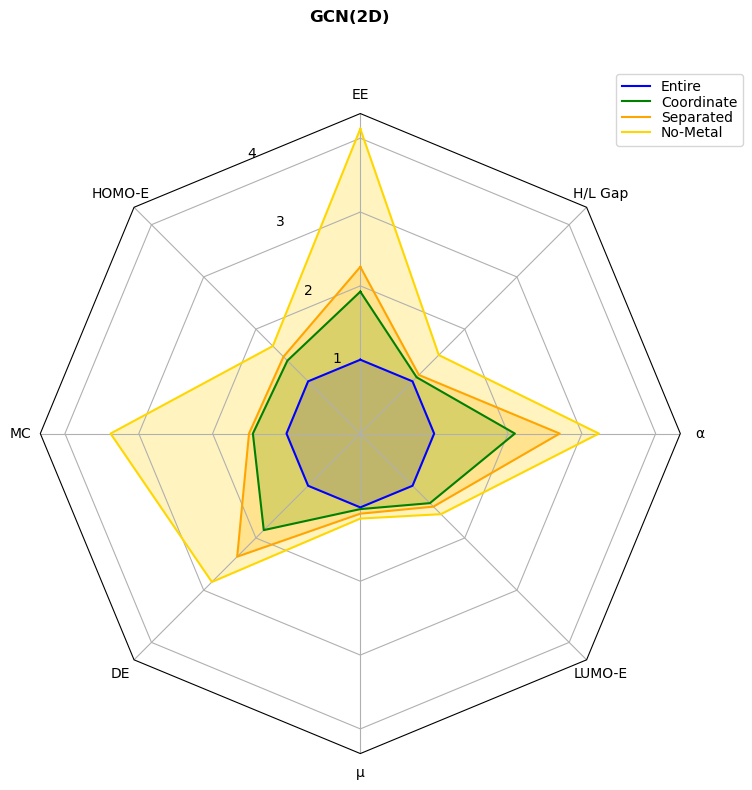

In [14]:
title = 'GCN(2D)'
experiments = ['SCnet-GCNs_en_no_laplace_2d_2d_1','SCnet-GCNs_se_att16_laplace_2d_2d_1','SCnet-GCNs_se_no_laplace_2d_2d_1','SCnet-GCNs_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','No-Metal']
radar(data,label,index,title)
areas.append(cal_area(data))

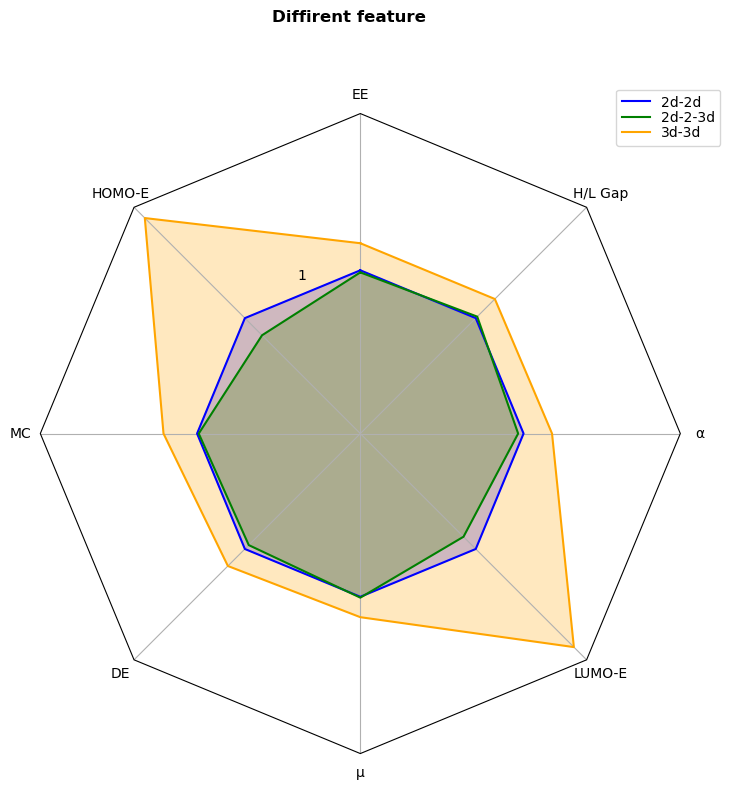

In [ ]:
title = 'Diffirent feature'
experiments = ['SCnet-GCN_se_att_laplace_2d_2d_1','SCnet-GCN_se_att_laplace_2d_2-3d_1','SCnet-GCN_se_att_laplace_3d_3d_1']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['2d-2d','2d-2-3d','3d-3d']
radar(data,label,index,title)
areas.append(cal_area(data))

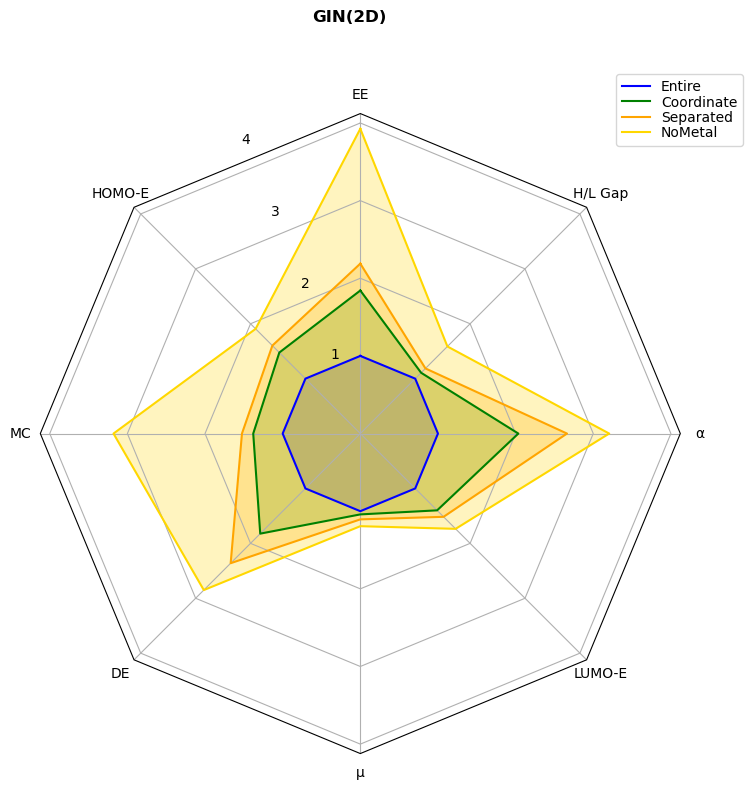

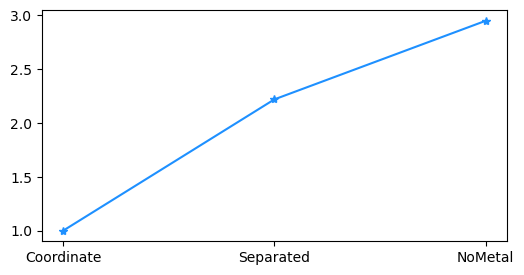

In [15]:
title = 'GIN(2D)'
experiments = ['SCnet-GIN_en_no_laplace_2d_2d_1','SCnet-GIN_se_att16_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,True,index[1:],title))

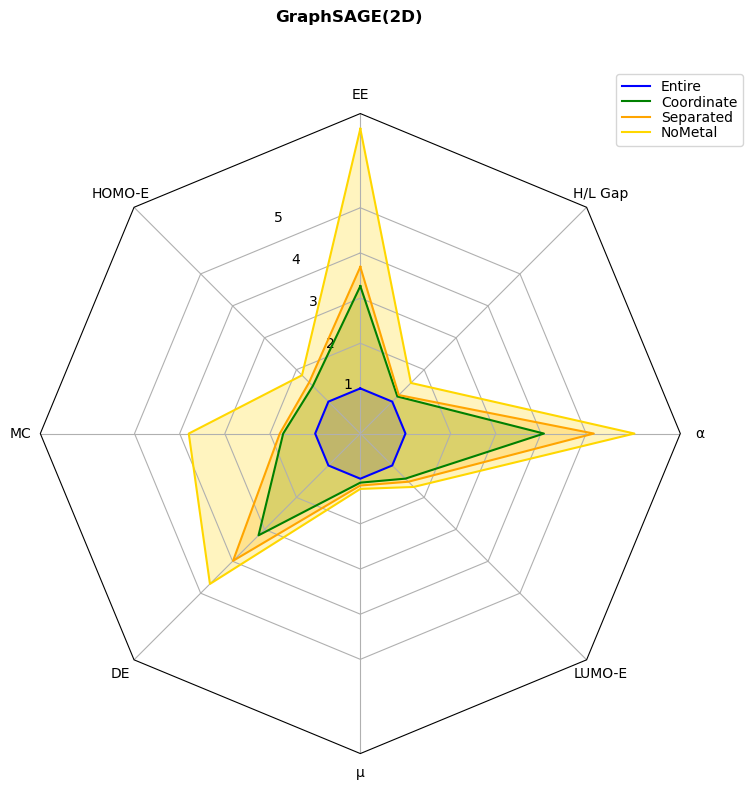

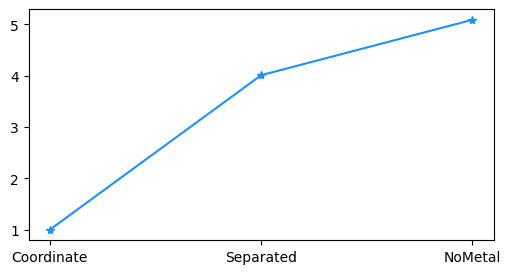

In [16]:
title = 'GraphSAGE(2D)'
experiments = ['SCnet-GraphSAGE_en_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_att16_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,True,index[1:],title))

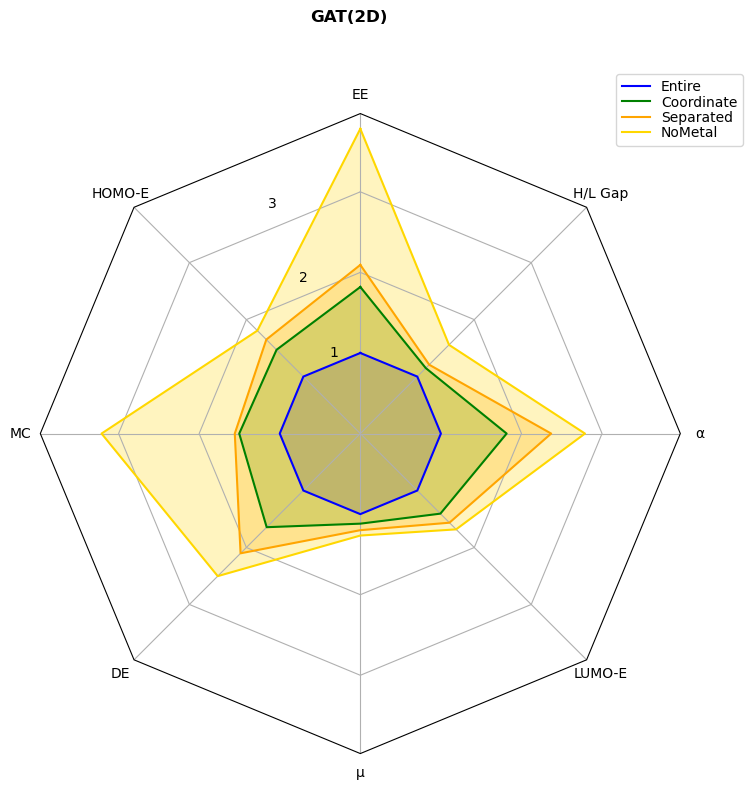

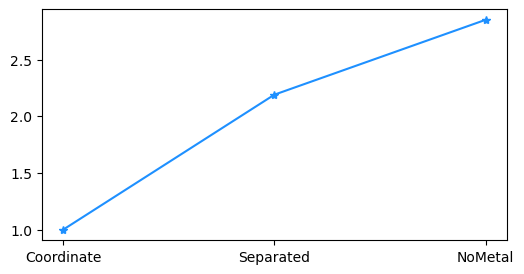

In [17]:
title = 'GAT(2D)'
experiments = ['SCnet-GAT_en_no_laplace_2d_2d_1','SCnet-GAT_se_att16_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,True,index[1:],title))

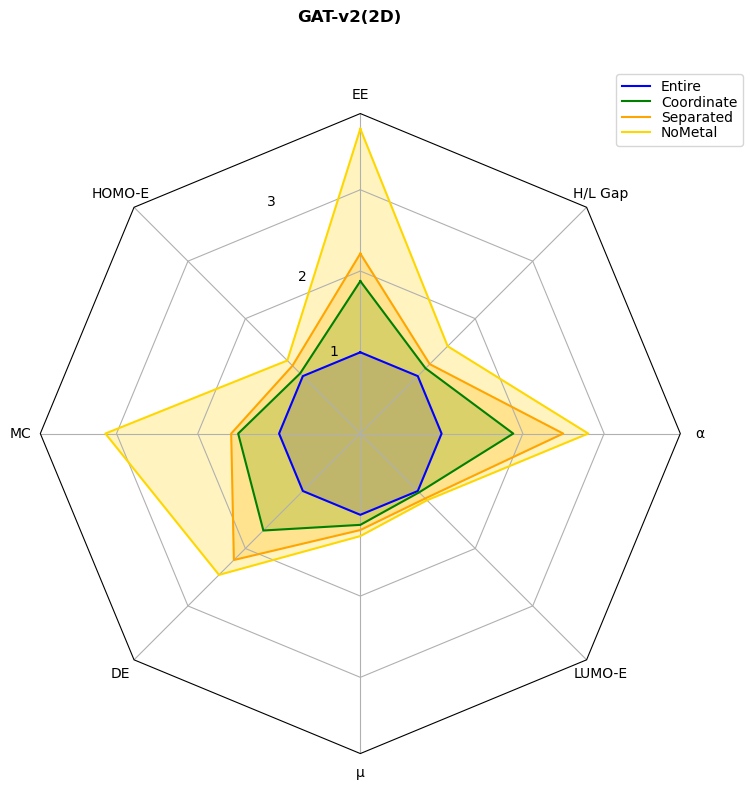

In [18]:
title = 'GAT-v2(2D)'
experiments = ['SCnet-GAT-v2_en_no_laplace_2d_2d_1','SCnet-GAT-v2_se_att16_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index,title))

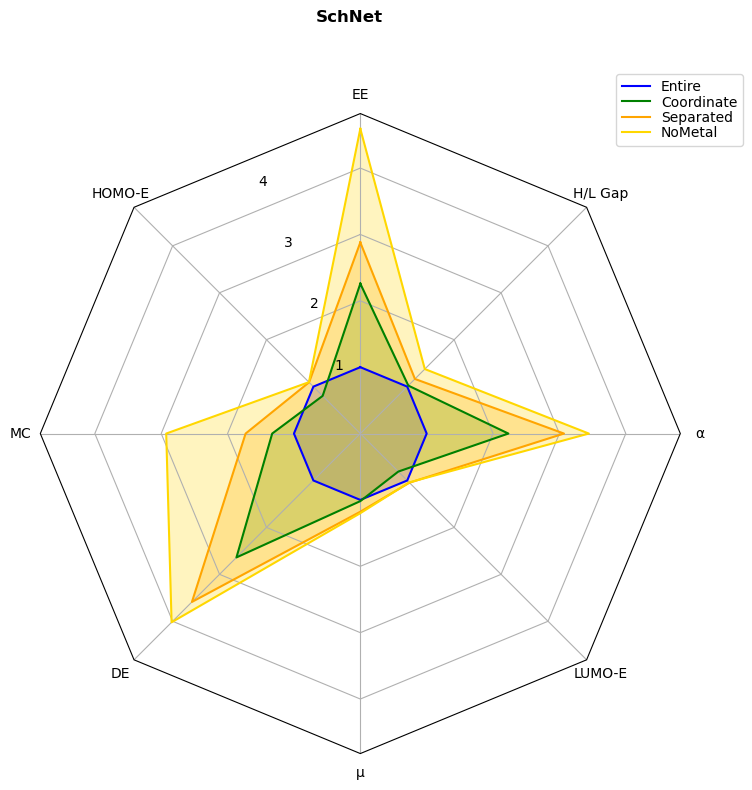

In [19]:
title = 'SchNet'
experiments = ['SchNet_en_no_xyz_3d_off_1','SchNet_se_att16_xyz_3d_2d_1','SchNet_se_no_xyz_3d_2d_1','SchNet_se_no_xyz_3d_off_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

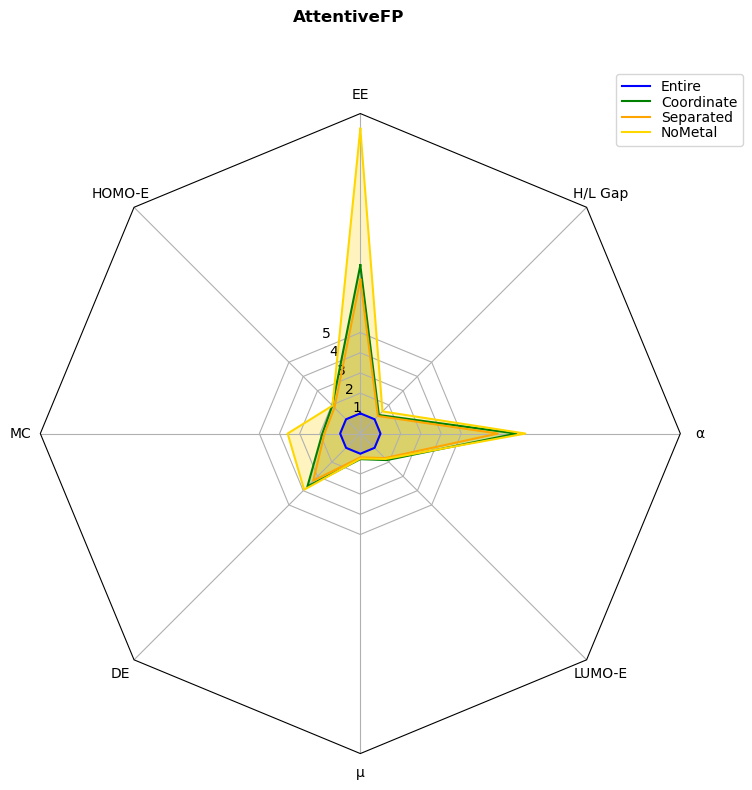

In [20]:
title = 'AttentiveFP'
experiments = ['AttentiveFP_en_no_xyz_2d_2d_1','AttentiveFP_se_att16_xyz_2d_2d_1','AttentiveFP_se_no_xyz_2d_2d_1','AttentiveFP_se_no_xyz_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

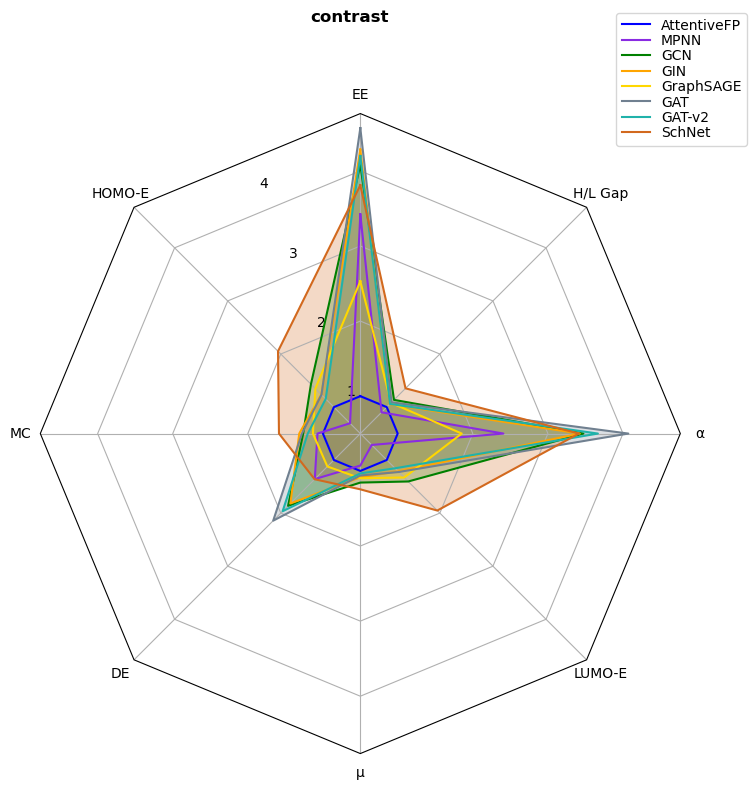

In [22]:
title = 'contrast'
experiments = ['AttentiveFP_en_no_xyz_2d_2d_1','SCnet-GCN_en_no_laplace_2d_2d_1','SCnet-GCNs_en_no_laplace_2d_2d_1','SCnet-GIN_en_no_laplace_2d_2d_1','SCnet-GraphSAGE_en_no_laplace_2d_2d_1','SCnet-GAT_en_no_laplace_2d_2d_1','SCnet-GAT-v2_en_no_laplace_2d_2d_1','SchNet_en_no_xyz_3d_off_1']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['AttentiveFP','MPNN','GCN','GIN','GraphSAGE','GAT','GAT-v2','SchNet']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

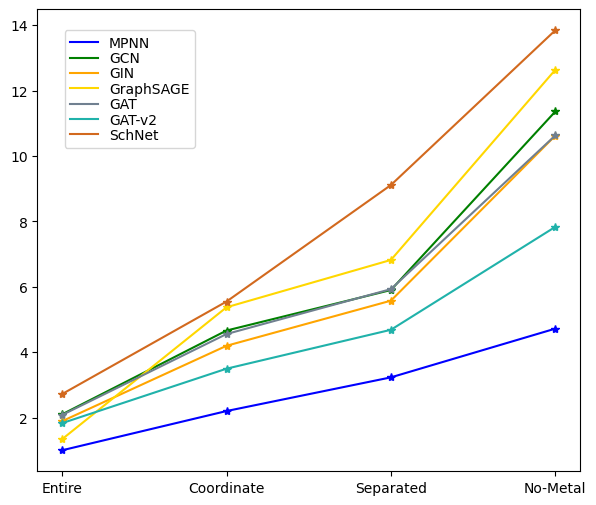

In [139]:
data = np.array(areas[:8])
for i in range(7):
    data[i,:] *= areas[7][i]
plt.figure(figsize=(7,6))
title = 'contrast'
index = ['Entire','Coordinate','Separated','No-Metal']
colors = ['blue','blueviolet','green', 'orange','gold','slategray','lightseagreen','chocolate']
labels = ['MPNN','GCN','GIN','GraphSAGE','GAT','GAT-v2','SchNet']
for i in range(7):
    plt.plot(index,data[i,:],'-',color=colors[i],label=labels[i])
    plt.plot(index,data[i,:],'*',color=colors[i])
legend = plt.legend(loc=(0.05, .7),labelspacing=0.1, fontsize='medium')
plt.savefig('./results/'+title+'.tif',dpi=600)
plt.show()

#### 制表

In [105]:
title = 'MPNN(2D)'
experiments = ['SCnet-GCN_en_no_laplace_2d_2d_1','SCnet-GCN_se_att_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
table(experiments,title,index,'a')

In [106]:
title = 'GCN(2D)'
experiments = ['SCnet-GCNs_en_no_laplace_2d_2d_1','SCnet-GCNs_se_att16_laplace_2d_2d_1','SCnet-GCNs_se_no_laplace_2d_2d_1','SCnet-GCNs_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
table(experiments,title,index,'a')

In [115]:
title = 'MPNN(3D)'
experiments = ['SCnet-GCN_en_no_laplace_3d_3d_1','SCnet-GCN_se_att_laplace_3d_3d_1','SCnet-GCN_se_no_laplace_3d_3d_1']
table(experiments,title)

In [107]:
title = 'GIN(2D)'
experiments = ['SCnet-GIN_en_no_laplace_2d_2d_1','SCnet-GIN_se_att16_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
table(experiments,title,index)

In [108]:
title = 'GraphSAGE(2D)'
experiments = ['SCnet-GraphSAGE_en_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_att16_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
table(experiments,title,index)

In [109]:
title = 'GAT(2D)'
experiments = ['SCnet-GAT_en_no_laplace_2d_2d_1','SCnet-GAT_se_att16_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
table(experiments,title,index)

In [110]:
title = 'GAT-v2(2D)'
experiments = ['SCnet-GAT-v2_en_no_laplace_2d_2d_1','SCnet-GAT-v2_se_att16_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','No-Metal']
table(experiments,title,index)

In [ ]:
title = 'SchNet'
experiments = ['SchNet_en_no_xyz_3d_off_1','SchNet_se_att16_xyz_3d_2d_1','SchNet_se_no_xyz_3d_2d_1','SchNet_se_no_xyz_3d_off_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
cal_area(data,False,index[:-1],title)

In [9]:
title = 'AttentiveFP'
experiments = ['AttentiveFP_en_no_xyz_2d_2d_1','AttentiveFP_se_att16_xyz_2d_2d_1','AttentiveFP_se_no_xyz_2d_2d_1','AttentiveFP_se_no_xyz_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index,'a')

#### 参数分析

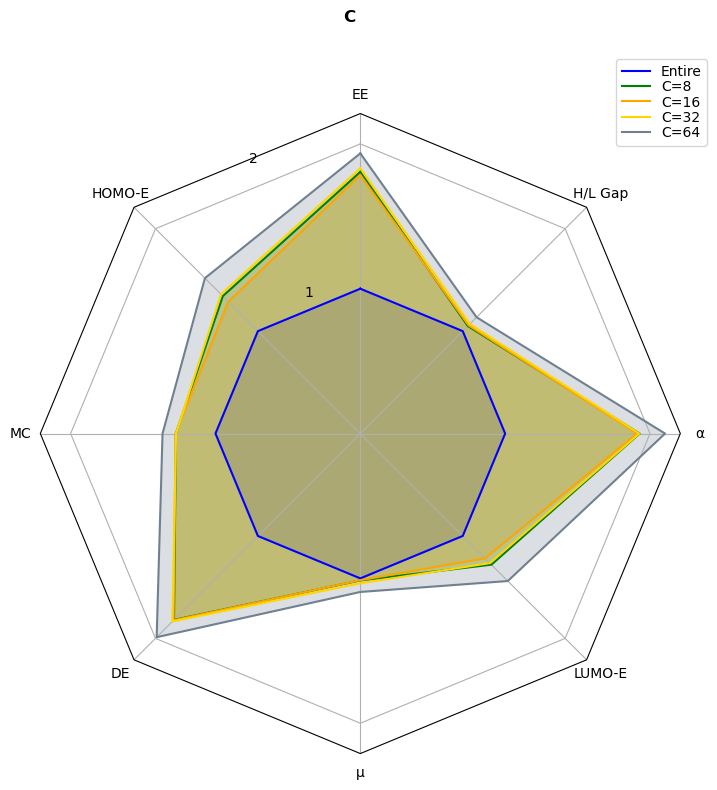

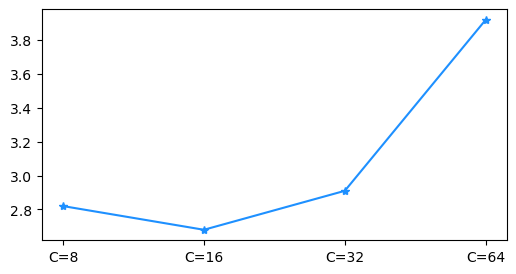

[2.82, 2.68, 2.91, 3.92, -2.83]

In [12]:
title = 'C'
index = ['Entire','C=8','C=16','C=32','C=64']
experiments = ['SCnet-GCN_en_no_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att8_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att16_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att32_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att64_laplace_2d_2-3d_1']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
cal_area(data,plot=True,lable=index[1:],title='C-line')

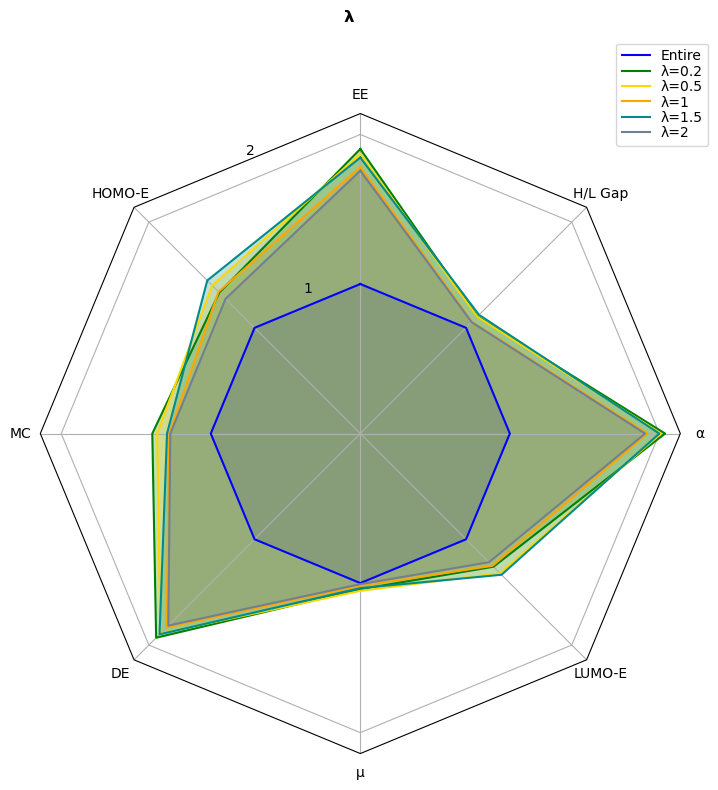

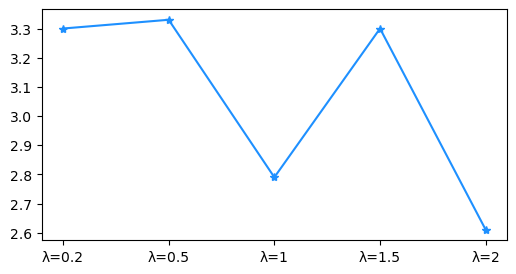

[3.3, 3.33, 2.79, 3.3, 2.61, -2.83]

In [171]:
title = '\u03BB'
index = ['Entire','\u03BB=0.2','\u03BB=0.5','\u03BB=1','\u03BB=1.5','\u03BB=2']
experiments = ['SCnet-GCN_en_no_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att_laplace_2d_2-3d_0.2',
               'SCnet-GCN_se_att_laplace_2d_2-3d_0.5',
               'SCnet-GCN_se_att_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att_laplace_2d_2-3d_1.5',
               'SCnet-GCN_se_att_laplace_2d_2-3d_2']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
cal_area(data,plot=True,lable=index[1:],title='C-line')

#### 可解释性

In [20]:
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)

In [11]:

dataset = tmQM_dataset(config['path'],config['separated'],config['data']['pe'])
dataloader = tmQM_wrapper(config['path'],config['batch_size'],separated=config['separated'],predata=dataset,**config['data'])
complexes = dataset.complexes
adjs = dataset.adjs
nodes = dataset.nodes
with open('./dataset/Data/start.pkl','rb') as f:
    start = pickle.load(f)

ERROR SAMPLE:GEJBUS
ERROR SAMPLE:OKAPEX


In [21]:
def importance(idx,model,start,dataset):
    with torch.no_grad():
        model.eval()
    _,weight,s = model(dataset[idx])
    imp = s.squeeze() @ weight.squeeze().T
    imp_sort = torch.argsort(imp)

    acc = False

    temp = []

    for node in nodes[idx]:
        temp += node

    m = 0
    n = len(temp)
    for s in start[idx]:
        if s in temp:
            m += 1
    for i in imp_sort[-3:]:
        if temp[i] in start[idx]:
            acc = True
            break
    prop = 1 - (math.factorial(n-m)/math.factorial(n-m-3))*((math.factorial(n-3)/math.factorial(n)))

    return imp,acc,prop

In [22]:
def cal_acc(model_name,path_list):
    config['model'] = model_name
    Acc = []
    for path in path_list:
        model = SCnet(
                    GNN_config=config['GNN'],
                    Coor_config=config['Coor_config'],
                    out_dimention=config['out_dimention'],
                    separated=config['separated'],
                    attention=config['attention'],
                    gnn=config['model']
                )
        net = torch.load(path)
        model_dict = model.state_dict()
        model_dict.update(net)
        model.load_state_dict(model_dict)
        imp_list = []
        acc_list = []
        prop_list = []
        error = []
        right = []
        for i in range(len(dataset)):
            try:
                imp,acc,prop = importance(i,model,start,dataset)
                imp_list.append(imp)
                acc_list.append(acc)
                prop_list.append(prop)
                right.append(i)
            except:
                error.append(i)
        Acc.append({sum(acc_list)/len(acc_list)})
        print(f'ACC:{sum(acc_list)/len(acc_list)}')
    return Acc

In [23]:
import os

def get_subdirectories(folder_path):
    subdirectories = [f.path+'/checkpoints/model.pth' for f in os.scandir(folder_path) if f.is_dir()]
    return subdirectories

In [24]:
root = './experiment/MPNN_se_att16_laplace_2d_2d_1/'
path_list = get_subdirectories(root)

In [28]:
Acc = cal_acc('MPNN',path_list[4:])

In [12]:
acc = np.array([0.5323,0.6007,0.6920,0.7481])

In [14]:
np.std(acc)

0.08290127788520511

In [320]:
import networkx as nx
def draw_ligands(index,complexes,adjs,nodes,sub_ind=None):
    print(complexes[index]['CSD_code'])
    atoms = [complexes[index]['atoms'][i] 
             for i in range(len(complexes[index]['atoms'])) 
             if i != complexes[index]['metal_pos']]
    adj = adjs[index]
    node = nodes[index]
    if sub_ind == None:
        fig,axes = plt.subplots(1,len(node),figsize=(30,10))
        node_code = 0
        for ind,ax in enumerate(axes):
            labels = {}
            for i,v in enumerate(node[ind]):
                node_code += 1
                labels[i] = atoms[v]+str(node_code)
            G = nx.Graph(adj[ind])
            pos = nx.spring_layout(G,seed=3113794655)
            nx.draw(G,pos,ax=ax,font_weight='bold')
            nx.draw_networkx_labels(G,pos,labels,ax=ax)
        plt.show()
    else:
        labels = {}
        for i,v in enumerate(node[sub_ind]):
            labels[i] = atoms[v]
        G = nx.Graph(adj[sub_ind])
        pos = nx.spring_layout(G, seed=3113794652)
        nx.draw(G,pos,font_weight='bold')
        nx.draw_networkx_labels(G,pos,labels)
        plt.show()

In [384]:
imp_sort

tensor([48, 46, 36, 44, 34, 38, 52, 32, 53, 42, 43, 33, 15, 58, 54,  7, 41, 35,
        45, 51, 23, 18, 13, 61, 55, 21,  2,  6, 11, 59, 50, 37, 47, 40, 17, 49,
        12, 39, 31,  8, 60, 56,  9,  5, 57, 19, 16, 10, 20,  3, 29, 30, 25, 22,
        24,  1, 28, 27, 14, 26,  4])

False
0.2751607247223846
RICSIF


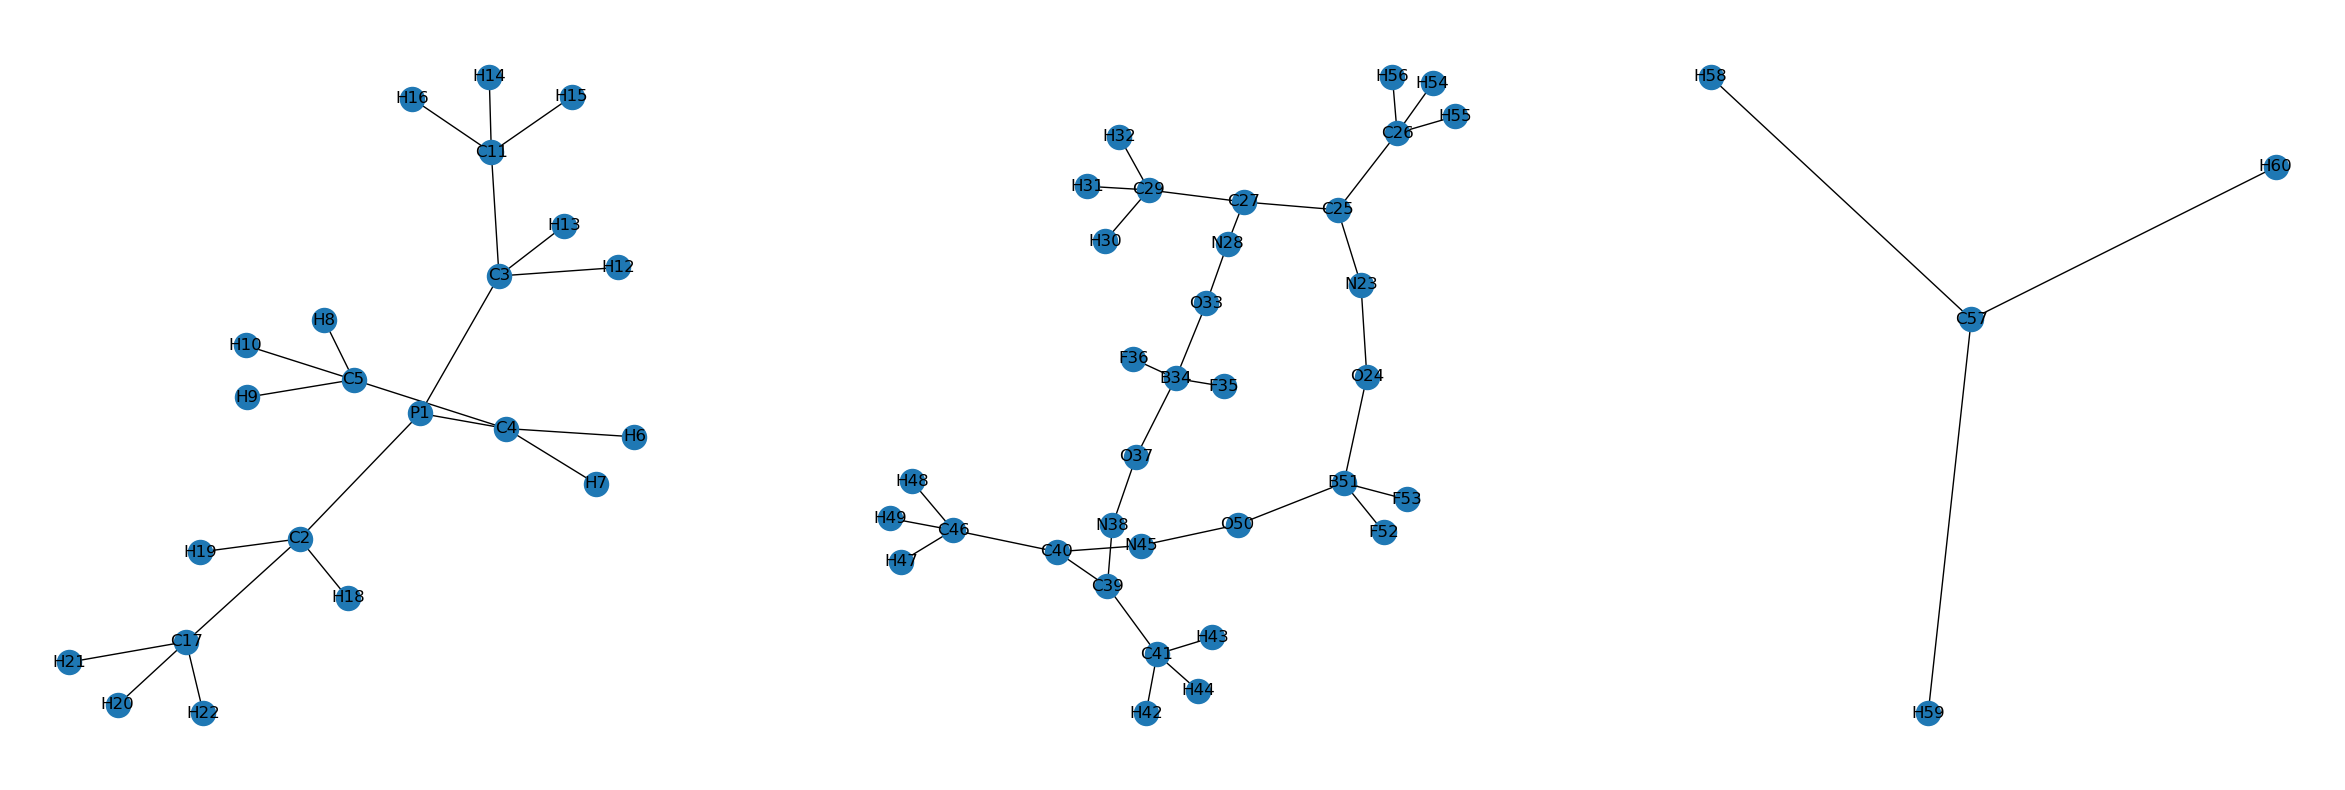

In [404]:
ind = 40131
imp,acc,prop = importance(ind,model,start,dataset)
imp_sort = torch.argsort(imp)+1
scale_imp = (imp-min(imp))/(max(imp)-min(imp))
print(acc)
print(prop)
draw_ligands(ind,complexes,adjs,nodes)

In [74]:
atoms = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,21,22,23,24,26,30,32,36,37,38,39,40]

Color for value 0.011917809024453163: (0.9594002306805075, 0.9784083044982699, 0.9970472895040369, 1.0)


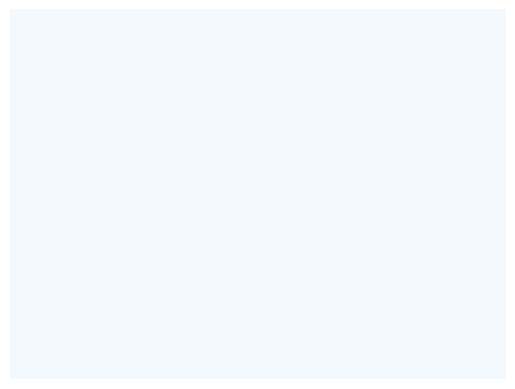

In [435]:
from matplotlib.colors import Normalize
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# 获取特定值对应的颜色
imp_ind = 57
specific_value = scale_imp[imp_ind-1].item()
color_for_specific_value = plt.cm.Blues(norm(specific_value))

# 打印颜色
print(f"Color for value {specific_value}: {color_for_specific_value}")

fig, ax = plt.subplots()
ax.imshow([[color_for_specific_value]], aspect='auto', extent=(0, 1, 0, 1))
ax.set_axis_off()

#### 回归图

In [44]:
model_path = './experiment/MPNN_en_no_xyz_2d_2d_1/Jan21_22-49-01_MPNN_en_no_xyz_2d_2d_1/checkpoints/'
f = open('./experiment/MPNN_en_no_xyz_2d_2d_1/testset.pkl','rb')
test_idx = pickle.load(f)
config = yaml.load(open(model_path+"config.yaml", "r"), Loader=yaml.FullLoader)
model = SCnet(
            GNN_config=config['GNN'],
            Coor_config=config['Coor_config'],
            out_dimention=config['out_dimention'],
            separated=config['separated'],
            attention=config['attention'],
            gnn=config['model']
        )
net = torch.load(model_path+'model.pth')
model_dict = model.state_dict()
model_dict.update(net)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [55]:
dataset = tmQM_dataset(config['path'],config['separated'],config['data']['pe'],index_list=test_idx)
dataloader = tmQM_wrapper(config['path'],config['batch_size'],separated=config['separated'],predata=dataset,valid_size=0,test_size=1)

In [57]:
def prediction(dataloader,model):
    pred = []
    label = []
    mean = np.array([-2.9521e+03, -1.4104e-01,  5.7462e+00,  1.5041e-01,  1.0927e-01,
            -1.9830e-01, -8.9036e-02,  3.9351e+02])
    std = np.array([1.6088e+03, 6.9794e-02, 3.8898e+00, 7.9519e-01, 3.3880e-02, 5.4259e-02,
            5.5013e-02, 1.5179e+02])
    _,_,test = dataloader.get_data_loaders()
    with torch.no_grad():
        model.eval()
    for _,data in enumerate(test):
        pred.append(model(data))
        label.append(data.y.reshape(-1,8))
    pred = torch.cat(pred,dim=0).detach().numpy()
    label = torch.cat(label,dim=0).numpy()
    pred = mean + pred * std

    return pred,label

In [47]:
color = 'mediumblue'
from matplotlib.colors import to_rgba
to_rgba(color)

(0.0, 0.0, 0.803921568627451, 1.0)

In [58]:
def regression(p,t,title=None):
    ref = [min(t),max(t)]
    plt.figure(figsize=(6,6))
    plt.plot(ref,ref,'--',color='red')
    plt.scatter(t,p,color=(0.03125, 0.24609, 0.5078125, 0.05),edgecolors=(1,1,1,0))
    R2 = sm.r2_score(t,p)
    rmse = np.sqrt(sm.mean_squared_error(t,p))
    mae = sm.mean_absolute_error(t,p)
    plt.text(np.min(t)+0.08*(np.max(t)-np.min(t)),np.max(t)-0.08*(np.max(t)-np.min(t)),'$R^2$ = {}'.format(np.around(R2,4)),fontsize='large')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    if title != None:
        plt.savefig('./results/'+title+'.tif',dpi=600)
    plt.show()

In [59]:
pred,label = prediction(dataloader,model)

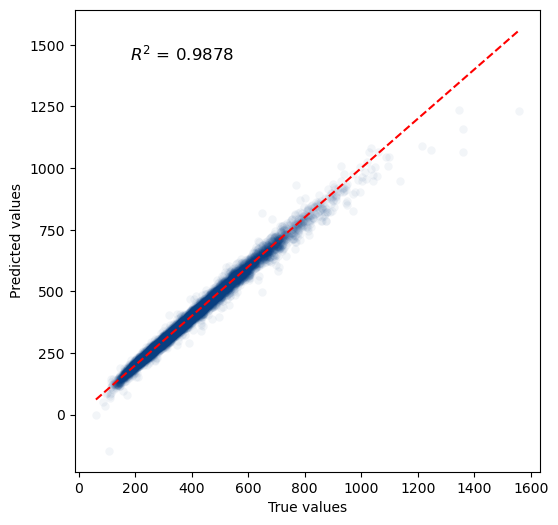

In [68]:
ind = 7
regression(pred[:,ind],label[:,ind],'MPNN2D(5)')

#### QM9实验

In [2]:
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
dataloader = tmQM_wrapper(config['path'],config['batch_size'],separated=config['separated'],**config['data'])
train,valid,test = dataloader.get_data_loaders()

In [4]:
loader = enumerate(train)
_,data = next(loader)

In [5]:
data

DataBatch(x=[558, 4], edge_index=[2, 1146], edge_attr=[1146, 3], y=[32, 19], batch=[558], ptr=[33])